In this notebook, we provide example code for computing gravitional waveforms from extreme-mass-ratio inspirals using the local kludge scheme (AKA the Chimera) introduced in [Sopuerta & Yunes, 2011](https://arxiv.org/abs/1109.0572) (hereafter Ref. [1]). In the introduction we provide a brief overview of our numerical implementation of the Chimera in order to explain the user-level options in the evolution master functions.

# Introduction

Schematically, our implementation of the Chimera is as follows:

1. Numerically evolve the geodesic equation with the initial constants of motion and initial conditions for a time $\Delta{T}$.

2. Compute the multipole moment derivatives required for waveform generation. These (up to 3rd order) time derivatives are computed using finite differences.

3. Compute the multipole moment derivatives required for the self-force computation. These (up to 6th order) time derivatives are computed using Julia's base backslash operator to solve a linear system for the coefficients of a truncated Fourier series expansion of the multipole moments. With these coefficients, the derivatives are computed via analytic differentiation of the Fourier series.

4. Compute the self-acceleration, use this to update the constants of motion, and evolve the next piecewise geodesic with the updated constants. Continue until the EMRI has been evolved for the specified amount of time.

The parameters of used in this notebook are set in the "params.jl" file.

# Preliminaries

To change the number of threads, run the cell below and then change the notebook's kernel to the newly created one. The kernel might need to be refreshed before the new kernel comes up as an option.

In [1]:
# using IJulia
# installkernel("Julia 4 threads", env=Dict("JULIA_NUM_THREADS"=>"4"));
println("Number of threads = $(Threads.nthreads())")
println("Julia version = $(VERSION)")

Number of threads = 6
Julia version = 1.11.5


Upon running this notebook for the first time, the following cell must be evaluated.

In [2]:
# include("../dependencies.jl");

The underlying parameters used in this notebook can be changed in the "params.jl" file.

In [3]:
using HDF5, LaTeXStrings, Plots.PlotMeasures, Plots
include("params.jl");

# Compute inspiral

First do a short run to JIT compile the function

In [ ]:
@time Chimera.compute_inspiral(emri; JIT = true);

JIT compilation run complete.
 25.909023 seconds (46.28 M allocations: 2.155 GiB, 3.01% gc time, 99.08% compilation time)


Now run for the desired duration. Using six threads, it takes ~33 secs (after JIT compilation) to evolve this inspiral for a duration of 3 hours.

In [18]:
@time Chimera.compute_inspiral(emri);

File created: ../Results/Data/EMRI_sol_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_0.1_chi0_0.2_phi0_0.3_BL_time_lmax_mass_4_lmax_current_3.h5
 30.323097 seconds (11.23 M allocations: 466.645 MiB, 0.41% gc time, 0.02% compilation time)


# Plot constants of motion

We first load the data from the inspiral. (Note that the inspiral with the option inspiral_type = "Analytic" is done in Boyer-Lindquist time, so when loading the trajectory one should remove λ and dt_dλ from the function calls below.)

In [4]:
# load trajectory
if inspiral_type == "Fitted"
    λ, t, r, θ, ϕ, dr_dt, dθ_dt, dϕ_dt, d2r_dt2, d2θ_dt2, d2ϕ_dt2, dt_dλ = Chimera.load_trajectory(emri);
elseif inspiral_type == "Analytic"
    t, r, θ, ϕ, dr_dt, dθ_dt, dϕ_dt, d2r_dt2, d2θ_dt2, d2ϕ_dt2 = Chimera.load_trajectory(emri);
end
t = t * MtoSecs;

# load fluxes
t_Fluxes, EE, LL, QQ, CC, pArray, ecc, θminArray = Chimera.load_constants_of_motion(emri);
t_Fluxes, Edot, Ldot, Qdot, Cdot = Chimera.load_fluxes(emri);

t_Fluxes = t_Fluxes * MtoSecs;

# compute iota
ι = @. acos(LL / sqrt(LL^2 + CC));

In [5]:
col = :blue
ls = :solid
lw = 2.0

wave_im_ratio = 5   # width / height
wave_height = 300; wave_width = wave_height * wave_im_ratio
xtickfontsize=10; ytickfontsize=10; guidefontsize=15;
# margins
left_margin = 8mm; right_margin=8mm; top_margin=8mm; bottom_margin=8mm;

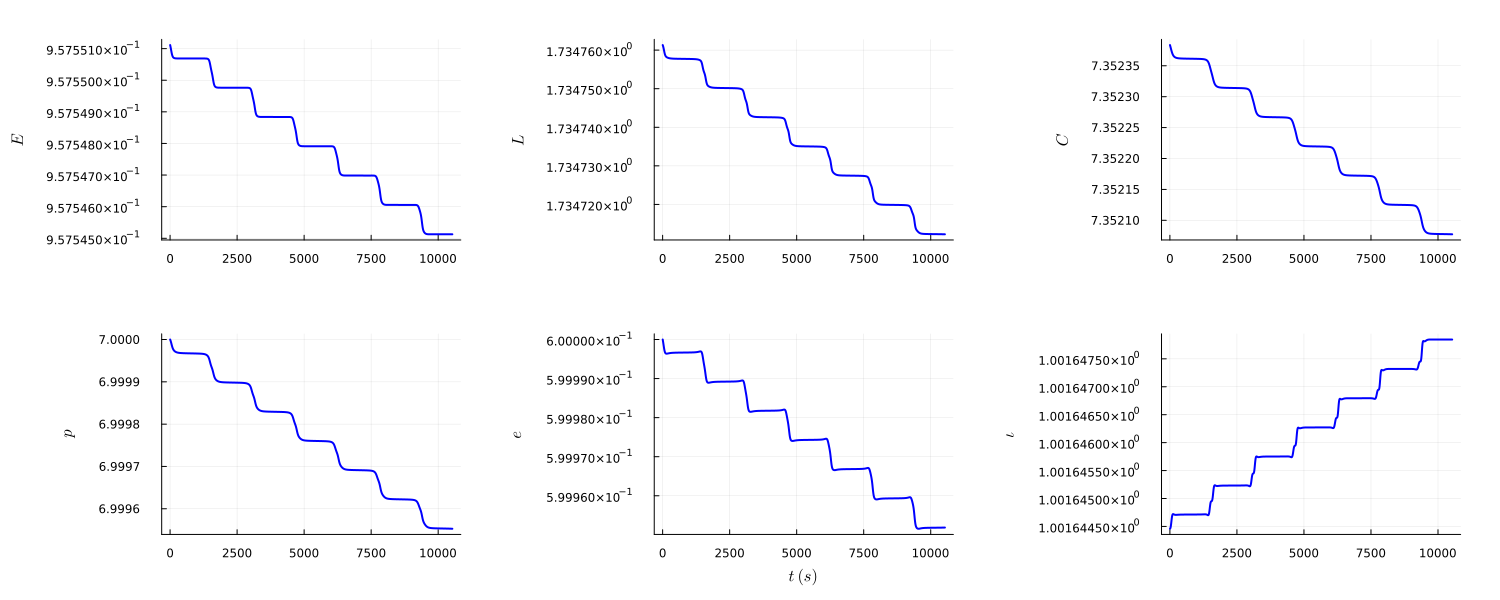

In [6]:
gr()
# plot BL results
plotE = Plots.plot(t_Fluxes, EE, ylabel=L"E", legend=:false,
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotL = Plots.plot(t_Fluxes, LL, ylabel=L"L", legend=:false,
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotC = Plots.plot(t_Fluxes, CC, ylabel=L"C", legend=:false,
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotP = Plots.plot(t_Fluxes, pArray, ylabel=L"p", legend=:false, 
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotEcc = Plots.plot(t_Fluxes, ecc, ylabel=L"e", xlabel=L"t\ (s)", legend=:false,
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)

plotι = Plots.plot(t_Fluxes, ι, ylabel=L"\iota", legend=:false,
    color=col, linestyle=ls, linewidth=lw,
    left_margin =  left_margin,
    right_margin =  right_margin,
    top_margin =  top_margin,
    bottom_margin =  bottom_margin)


orbitalParamsPlot=plot(plotE, plotL, plotC, plotP, plotEcc, plotι, layout = @layout([[A B C]; [D E F]]), 
size=(1500, 600), dpi=100)
display("image/png", orbitalParamsPlot)

# Waveform computation

We now compute and plot the waveforms. The plus/cross polarization vectors in the source frame are given by $\mathbf{x}_w$, $\mathbf{y}_w$ as defined in Eq. 6 in [2104.04582](https://arxiv.org/pdf/2104.04582).

In [28]:
@time Chimera.compute_waveform(emri);

File created: ../Results/Data/Waveform_a_0.98_p_7.0_e_0.6_θmin_0.571_q_1.0e-5_psi0_0.1_chi0_0.2_phi0_0.3_obsDist_1.0_ThetaS_10.0_PhiS_5.0_ThetaK_6.0_PhiK_8.0_BL_time_lmax_mass_4_lmax_current_3.h5
  2.048032 seconds (176.93 M allocations: 2.755 GiB, 25.34% gc time)


In [7]:
t_wf, h_plus, h_cross = Chimera.load_waveform(emri);
t_wf *= MtoSecs;

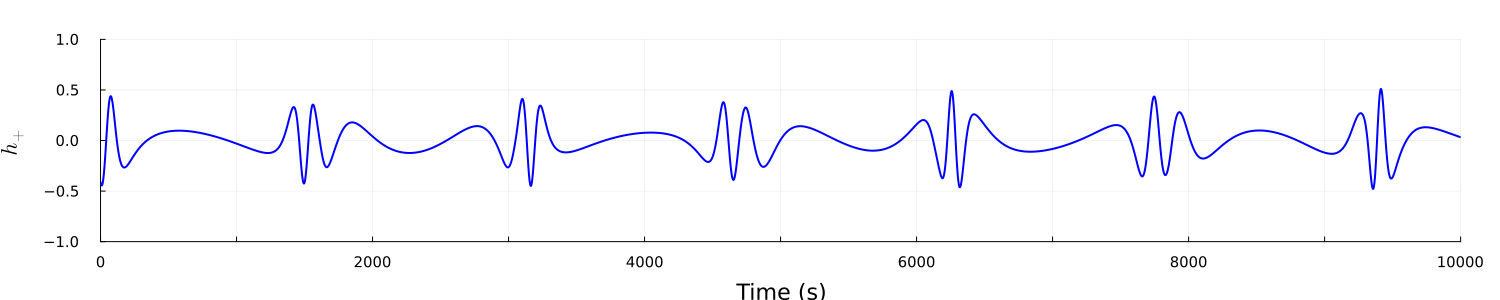

In [8]:
# NOTE: can multiply by "strain_to_SI" to convert waveform to SI units
gr()
p1 = plot(t_wf, h_plus, 
color=col,
linestyle=ls,
linewidth=lw,
xlims=(0, 10000),
legend =false,
xticks=(0:1000:10000, ["0", "", "2000", "", "4000", "", "6000", "", "8000", "", "10000"]),
xlabel = "Time (s)",
ylabel = L"h_{+}",
size=(wave_width, wave_height),
left_margin		=  left_margin,
right_margin	=  right_margin,
top_margin		=  top_margin,
bottom_margin	=  bottom_margin,
xtickfontsize = xtickfontsize,
ytickfontsize = ytickfontsize,
guidefontsize = guidefontsize,
ylims = (-1, 1),
dpi=100)

# plot!(p1, t_wf, h_plus, color=col_2, linestyle=ls_2, linewidth=lw_2, label="All Modes")

display("image/png", p1)